## Formatting the data
The data available is not perfect. Some articles have missing information. Such texts will be filtered out - The data will be loaded from a JSON and converted to a Pandas dataframe. 

The necessary features are: __Domain, Body, Header__ and __Byline__. URI is nice to have, but not necessary.

Author: lkt259@alumni.ku.dk

In [1]:
import numpy as np
import pandas as pd
import os, re
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from scipy.stats.stats import pearsonr
import random
from difflib import SequenceMatcher
from dateutil.parser import parse
plt.style.use('seaborn')

scrape = False

/tmp/ipykernel_290/1015014850.py:6: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
#Load data - and show 120 characters of the body.
data = pd.read_json(r'data/data_0.json')
pd.set_option('display.max_colwidth', 220)
data.head(3)

ValueError: Expected object or value

### Removing duplicates and empty bodies
We don't want duplicate articles. First, we'll remove entries with the same URI and body. I save the entries, which have empty bodies and unique URI's - Perhaps we can get the body online, if needed.

In [3]:
def print_stats():
    print(f"{data.shape[0]} entries.")
    print(f"{data.Byline.unique().shape[0]} authors.")
    print(f"{data.Domain.unique().shape[0]} domains.")

def same_uri(uri):
    return data[data['Uri']==uri]

def remove_duplicates(data):
    print("With duplicates:", data.shape)
    data = data.drop_duplicates(subset=["Body", "Uri"]) #Remove entries with same body and URI
    empty_bodies = data[data['Body'] == '']    #Save empty bodied entries in another dataframe.
    data = data[data['Body'] != '']
    empty_bodies = empty_bodies[~empty_bodies['Uri'].isin(data['Uri'])] #Remove empty bodies, which are present in data.
    duplicate_bodies = data[data.duplicated(subset=["Body"])]
    data = data.drop_duplicates(subset=['Body']) #Can remove all duplicate bodies here, after None-bodies are removed.
    data = data.drop_duplicates(subset=["Uri"]) #Remove entries with same URI
    
    print("Without duplicates:", data.shape)
    return data, empty_bodies, duplicate_bodies

data, _, _ = remove_duplicates(data)

NameError: name 'data' is not defined

### Removing unknown authors, headers and domains

In [4]:
def remove_missing_feats(data):
    no_author, no_header, no_domain = None, None, None
    
    if data['Byline'].isnull().values.any(): #Missing authors
        no_author = data[data['Byline'].isnull()]
        data = data.dropna(subset=['Byline'])
        print("Without unknown authors:", data.shape)

    if data['Header'].isnull().values.any():
        no_header = data[data['Header'].isnull()]
        data = data.dropna(subset=['Header'])
        print("Without unknown title:", data.shape)
    
    data = data[data.Header != '']

    if data['Domain'].isnull().values.any():
        no_domain = data[data['Domain'].isnull()]
        data = data.dropna(subset=['Domain'])
        print("Without unknown domains:", data.shape)
        
    return data, no_author, no_header, no_domain

data, _, _, _ = remove_missing_feats(data)

### Applying to all data files.
After investigating the data, let's apply the changes to the files. No need in formatting multiple times. Also, let's see how the distributions are when collecting all data.

In [5]:
#Load all data into one big dataframe. Oh yes, it is possible!
files = os.listdir('data')
files = [x for x in files if x[-4:]=='json'] #only take .json files.

data = pd.read_json('data/'+files[0])
for file in tqdm(files[1:]):
    data = pd.concat([data, pd.read_json('data/'+file)])

print_stats()

  0%|          | 0/80 [00:00<?, ?it/s]

808066 entries.
66994 authors.
268 domains.


In [6]:
#Used for plotting later...
body_lengths = data['Body'].str.len()
y2, bin_edges = np.histogram(body_lengths, bins=150, range=(0,15000))
x2 = 0.5*(bin_edges[1:] + bin_edges[:-1])

#### Remove duplicated and missing data
Some data did not meet the requirements. How much data do we have left?

In [7]:
data, empty_bodies, duplicate_bodies = remove_duplicates(data)
data, no_author, no_header, no_domain = remove_missing_feats(data)

#Removing bad authors. Baaad author, shame on you!
bad_byline = data[data['Byline']==data['Uri']]
data = data[data['Byline']!=data['Uri']]
print("With bad authors removed:", data.shape)
print_stats()

With duplicates: (808066, 8)
Without duplicates: (431531, 8)
Without unknown authors: (398856, 8)
With bad authors removed: (348751, 8)
348751 entries.
7849 authors.
205 domains.


In [8]:
#Titel-ize Authors!
data.Byline = data.Byline.str.title()
print("Unique authors: ", len(data['Byline'].value_counts()))
print(data['Byline'].value_counts()[:-5],"\n...")

Unique authors:  7776
Anne Sophia Hermansen                                  13559
Karim Pedersen                                          7157
Thomas Treo                                             6172
Mads Elkær                                              4898
Benny Baagø                                             4271
                                                       ...  
Emil Bergløv | Sofie Synnøve Herschend                     1
Jo Carlsenn | Rie Carlsen                                  1
Kasper Schütt-Jensen | Mads Frost                          1
Steen Nedell Christensen | Jesper Haue Hansen              1
Michael Hjøllund | Jacob Haislund | Jesper Kongstad        1
Name: Byline, Length: 7771, dtype: int64 
...


In [9]:
print(len(empty_bodies), "empty bodies")
print(len(no_author), "without author")
#print(len(no_header), "without header")
#print(len(no_domain), "without domain")
print(len(bad_byline), "malformed authors")

448 empty bodies
32675 without author
28789 malformed authors


### Author cleanup! Removing multiple authors.
Some entries have multiple auhthors. How big a problem does this cause?

In [10]:
authors = list(data['Byline'])[1:] #First entry is empty.
multiple_authors_candidates = []
for author in authors:
    if any(x in author for x in ['|',',']):
        multiple_authors_candidates.append(author)

print("Entries with multiple authors (and titles, cities):" ,len(multiple_authors_candidates))
print(f"Unique combinations of authors: {len(set(multiple_authors_candidates))}")

#multiple_authors = [re.split('\||,',x) for x in multiple_authors]

Entries with multiple authors (and titles, cities): 11275
Unique combinations of authors: 4747


**Now! Let us remove entries with multiple authors.**

Some authors are actually not multiple authors, but cities and titles. These entries will be kept, but stripped from everything except the name. We don't want multiple authors, as this project focuses on single authors.

In [11]:
#Read txt file with words that should not be masked.
with open('data/additional/author_filter.txt', encoding='utf-8') as f:
    lst = f.read()
    lst = lst.split('\n')

author_filter = lst

print(f"{len(set([x for x in multiple_authors_candidates if '|' in x]))} authors removed by '|-rule'")
bar_rule = [x for x in multiple_authors_candidates if '|' in x]
multiple_authors_candidates = [x for x in multiple_authors_candidates if '|' not in x] #Remove entries with | in them.

new_authors_candidates = []
author_names_without_city = [] #Save the new, stripped name and the old one, to edit data fterwards.

for candidate in multiple_authors_candidates:
    names = candidate.split(',') #Split by , to separate authors or cities    
    
    append = True
    
    #Loop through names
    for name in names:
        name = name.strip()
        if len(name.split())>1: #Name is not two or more names.
            if any(ele in name for ele in author_filter): #Do not append if name found in filter.
                append = False
        else:
            append = False
    
    if append:
        new_authors_candidates.append(candidate)
    else:
        #Append to names list without cities. 
        if any(ele in names[0] for ele in author_filter): #If first name appears in filter, use second name.
            author_names_without_city.append((names[1], candidate))
        else:
            author_names_without_city.append((names[0], candidate))
            
print(f"{len(set(new_authors_candidates))} author combinations removed by filter.")
print(f"Kept {len(set([x[0] for x in author_names_without_city]))} authors (Not sure if they are new authors yet).")

already_there_hon = 0
uniques = data['Byline'].unique()
for i in set([x[0] for x in author_names_without_city]):
    if i in uniques:
        already_there_hon += 1
        
print(f"{already_there_hon} authors already present in data by themselves.")

2896 authors removed by '|-rule'
1463 author combinations removed by filter.
Kept 215 authors (Not sure if they are new authors yet).
139 authors already present in data by themselves.


In [12]:
#Drop multiple authors from data.
data = data[data['Byline'].isin(new_authors_candidates) == False]
data = data[data['Byline'].isin(bar_rule) == False]

#Convert wrong names to right names in data.
#Badly optimised...
print("Converting names...")
for entry in tqdm(author_names_without_city):
    name = entry[0]
    wrong_name = entry[1]
    
    data.loc[data["Byline"] == wrong_name, "Byline"] = name
print("Names are converted! That was slow.")

Converting names...


  0%|          | 0/1442 [00:00<?, ?it/s]

Names are converted! That was slow.


In [13]:
## Remove authors: Redaktionen and Ritzau /Nyheder
data = data[data.Byline.isin(['Redaktionen', 'Ritzau /Nyheder']) == False]

In [14]:
print_stats()

336788 entries.
3103 authors.
205 domains.


## Removing Unique Entries
We don't want unique author or domain names. We need **at least** two entries for each.

In [15]:
#Drop rows where domain only occurs once.
d = data['Domain'].value_counts()
data = data[data['Domain'].isin(d[d<2].keys()) == False]

In [16]:
#Find which author names that can be salvaged. (Are they calpitalized?)
def unique_author_removal(data):
    d = data['Byline'].value_counts()
    unique_authors = d[d<2].keys()
    common_authors = d[d>2].keys()

    for author in unique_authors:
        author = author.strip()
        if author.istitle():
            continue
        if author.isupper() or author.islower():
            if author.title() in common_authors:
                data.loc[data["Byline"] == author, "Byline"] = author.title()

    #Remove any entries with single-occuring authors.
    data = data[data['Byline'].isin(unique_authors) == False]
    return data

data = unique_author_removal(data)

In [17]:
#Drop rows where domain only occurs once.
d = data['Domain'].value_counts()
data = data[data['Domain'].isin(d[d<2].keys()) == False]

In [18]:
print_stats()

335583 entries.
1906 authors.
193 domains.


### Additional cleanup
Removing duplicated headers and foreign domains.

In [19]:
h = data['Header'].value_counts()
data = data[data['Header'].isin(h[h>20][1:].keys())==False]

**Remove foreign domains** - We don't want German texts!

In [20]:
domains = ('.dk', 'nordicwomeninfilm.com', 'linkedin.com', 'betxpert.com', 'kommunikation.com', 'radar.com', 'ea.com', 'ue.com','ce.com', '.international', 'e.nu')
print(data[data['Domain'].str.endswith(domains)==False].shape[0], "entries with foreign domains.")
data = data[data['Domain'].str.endswith(domains)]
print_stats()

24924 entries with foreign domains.
307953 entries.
1867 authors.
162 domains.


__Duplicate domains:__ computerworld.dk has 3 domains of different formats. Unify them.

In [21]:
data.loc[data.Domain.isin(["Computerworld.dk", "www.computerworld.dk"]), 'Domain'] = 'computerworld.dk'

In [22]:
data[(data.Domain=='bt.dk') & (data.Header=='Din profil er oprettet')].Uri.head(200)

396                          https://www.bt.dk/royale/grevinde-alexandra-gaar-fra-kaeresten-i-dramatisk-brud
397                    https://www.bt.dk/royale/skuespillerinde-naegter-venskab-med-prins-harry-det-er-loegn
398                                     https://www.bt.dk/royale/kronprins-frederik-deler-billede-fra-jordan
399                                        https://www.bt.dk/kendte/jackie-navarro-raser-over-vilde-beskeder
400                                       https://www.bt.dk/udland/skovbrand-ude-af-kontrol-50.000-evakueret
                                                       ...                                                  
678                                    https://www.bt.dk/samfund/dansk-domstol-i-broeler-jeg-er-meget-rystet
696             https://www.bt.dk/kendte/endnu-en-stjerne-paa-onlyfans-spiller-guitar-splitterravende-noegen
697                                 https://www.bt.dk/film-tv-og-streaming/black-lives-matter-overtog-showet
698    https://www.

__Front and back cleanup:__ Remove first and last 100 characters of articles and check their length

In [5]:
def read_data(path): #input the path to the directory with data
    frames = []
    
    _, _, files = next(os.walk(path)) #create a list of all datafile names     
          
    for file in tqdm(files): #for every file in directory
        with open(path+"/"+file) as f: #read each file
            dataframe = pd.read_json(f) #convert file to dataframe
     
        frames.append(dataframe) #append each dataframe to list
    data = pd.concat(frames, sort=False) #make it one big dataframe
    
    return data

In [80]:
domain_data = read_data("Data/final_domain_subset")
author_data = read_data("Data/final_author_subset")


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

In [83]:
all_data = read_data("scraped")

  0%|          | 0/31 [00:00<?, ?it/s]

In [12]:
def remove_start_end(text): 
    new_text = text[100:]
    new_text = new_text[:-100]
    
    return new_text
    

In [101]:
def xtra_cleaner(dataframe, folder): 
    
    bad_indices = []
    print("OG dataframe len: ", len(dataframe))
    try:
        dataframe = dataframe.reset_index()
    except:
        pass
    
    for idx, article in tqdm(dataframe.iterrows()):
        
        body = article.Body
        
        new_body = remove_start_end(body) # remove first and last 100 characters
        
        #check length
        if len(new_body) < 200:
            bad_indices.append(idx)
        else: 
            dataframe.iloc[idx, dataframe.columns.get_loc('Body')] = new_body #overwrite old body with new
    
    dataframe = dataframe.drop(index=bad_indices) #remove articles under 200 characters
        
    #Save data
    n = 10000
    for g, df in dataframe.groupby(np.arange(len(dataframe)) // n):
        df.to_json(f'Data/{folder}/data_%s.json'%g, orient='records')
        
    print("Clean data saved")
    
    return dataframe, print(len(bad_indices), "articles were removed. New dataframe len: ", len(dataframe), "\n")
        
        

In [102]:
%%time
domain_df = xtra_cleaner(domain_data, "xtra_clean_domains")

OG dataframe len:  124058


0it [00:00, ?it/s]

Clean data saved
5842 articles were removed. New dataframe len:  118216 

CPU times: user 12.1 s, sys: 1.21 s, total: 13.3 s
Wall time: 14.5 s


In [105]:
%%time
author_df = xtra_cleaner(author_data, "xtra_clean_authors")

OG dataframe len:  115867


0it [00:00, ?it/s]

Clean data saved
3422 articles were removed. New dataframe len:  112445 

CPU times: user 12.5 s, sys: 1.54 s, total: 14.1 s
Wall time: 16 s


In [112]:
full_df = xtra_cleaner(all_data, "xtra_clean_headline_subset")

OG dataframe len:  300822


0it [00:00, ?it/s]

Clean data saved
9256 articles were removed. New dataframe len:  291566 



In [148]:
def headline_subsetter(dataframe, folder): 
    
    #Strip the bodies first 
    print("OG dataframe len: ", len(dataframe))
    
    try:
        dataframe = dataframe.reset_index()
    except:
        pass
    
    no_repeated_headers = dataframe.drop_duplicates(subset='Header', keep="first")
    
    #Save data
    n = 10000
    for g, df in no_repeated_headers.groupby(np.arange(len(no_repeated_headers)) // n):
        df.to_json(f'Data/{folder}/data_%s.json'%g, orient='records')
        
    print("Clean data saved")
    
    print(len(dataframe)-len(no_repeated_headers), "articles were removed due to repeating headers.")
    
    return no_repeated_headers, print("New dataframe len: ", len(no_repeated_headers), "\n")

In [149]:
head_sub = headline_subsetter(clean_data, "xtra_clean_headline_subset/no_dupes")

OG dataframe len:  291566
Clean data saved
76645 articles were removed due to repeating headers.
New dataframe len:  214921 



## Scrape 35k articles
Some articles have the same header, same body. The domains are limited to bt.dk and berlingske.dk - making a scraper is not too hard.

In [23]:
remove = []
import traceback

if scrape:
    try:
        data = data.reset_index()
    except:
        pass
    import SeleniumScraper
    
    treo = data[data['Byline']=='Thomas Treo']
    anne = data[data['Byline']=='Anne Sophia Hermansen']
    corrupt_data = data[data['Header']=='Din profil er oprettet']
    corrupt_data = pd.concat((corrupt_data, treo, anne))
    
    errors = []
    _404s = []
    
    i = 0
    o = corrupt_data.shape[0]

    for idx, article in tqdm(corrupt_data.iterrows()):
        url = article.Uri

        try:
            header, body, author = SeleniumScraper.get_content(url)

        except Exception as e:
            i += 1
            errors.append((url, e))
            remove.append(article.Id)
            print(traceback.format_exc())
            continue
    
        if type(author) == list:
            errors.append((url, f"MULTIPLE AUTHORS:{author}"))
            remove.append(article.Id)
            continue
        
        if article.Domain == 'bt.dk' or article.Domain == 'berlingske.dk':
            author, body = '404', '404'
            
        if header != '404':
            data.iloc[idx, data.columns.get_loc('Header')] = header
        else:
            _404s.append(url)
            continue
            
        if body != '404':
            data.iloc[idx, data.columns.get_loc('Body')] = body
            
        if author != '404':
            data.iloc[idx, data.columns.get_loc('Byline')] = author

        print(header, f"({i}/{o})")
        i += 1

print_stats()
data = data[data.Id.isin(remove)==False]
data.to_json(r'data/additional/scraped_data_raw.json')

307953 entries.
1867 authors.
160 domains.


ValueError: DataFrame index must be unique for orient='columns'.

In [24]:
#Remove the remaining unusable articles - those that could not be scraped.
data = data[data.Header != 'Din profil er oprettet']
data = unique_author_removal(data)
print_stats()

292448 entries.
1866 authors.
160 domains.


In [25]:
print_stats()

292448 entries.
1866 authors.
160 domains.


In [4]:
import os

In [145]:
# Re-load data for additional cleanup.
files = os.listdir('Data/subset')
files = [x for x in files if x[-4:]=='json'] #only take .json files.

data = pd.read_json('Data/subset/'+files[0])
for file in tqdm(files[1:]):
    data = pd.concat([data, pd.read_json('Data/subset/'+file)])

#data = pd.read_json('Data/additional/scraped_data_raw.json')

domains = data.Domain.value_counts()
domains1000 = domains[domains>=1000]
domains1000_list = list(domains1000.index)
#del domains1000_list[domains1000_list.index('bold.dk')]

del data['index']
del data['level_0']

data.reset_index(drop=True)

data = data[data['Domain'].isin(domains1000_list)]

  0%|          | 0/14 [00:00<?, ?it/s]

In [146]:
data[data.Header.str.contains('gigant-razzia')]

,Id,Domain,Body,Header,PublicationDate,Uri,Byline,TextHash


In [147]:
print_stats()

141426 entries.
99 authors.
31 domains.


### Define junk text

In [148]:
#This function will identify phrases that are repeated throughout the domains. 
#However, it will have multiple duplicate matches, making the conversion slow... Oh well...
def get_junk_by_domain(domain, verbose=False):
    bodies = data[data.Domain==domain].Body.to_list()
    junk = {}
    if verbose:
        print("Started on", domain)
    for i in tqdm(range(len(bodies)//4)):
        #Loop through a quarter of the bodies from the domain.
        randomindex = None

        while True:
            #Find a random index for a article
            randomindex = random.randint(0,len(bodies)-1)
            if randomindex != i:
                break
        
        #We now have to articles to compare
        string1 = bodies[i]
        string2 = bodies[randomindex]

        #match = SequenceMatcher(None, string1, string2).find_longest_match(0, len(string1), 0, len(string2))
        
        #Find the indices for the three longest identical substrings in the two articles.
        matches = SequenceMatcher(None, string1, string2).get_matching_blocks()
        
        #Last match is always useless. Loop through the matches.
        for match in matches[:-1]:
            if match.size > 20:
                #If match is longer than 20 characters, extract string from indices and add to dict.
                matchstr = string1[match.a: match.a + match.size] 
                if matchstr not in junk:
                    junk[matchstr] = 1
                else:
                    junk[matchstr] += 1
    
    if verbose:
        print(f"Found {len(junk)} sentences to remove in {domain}...")
    
    keys = list(junk.keys())
    if verbose:
        print(keys)
    junk_list = []
    
    #Loop through the junk found and add to a list, if they occur more than 2 times.
    for key in keys:
        if junk[key] > 2:
            junk_list.append(key)
    
    if verbose:
        print(f"Narrowed that down to {len(junk_list)} junk sentences.")
        print(f"Consisting of: {junk_list}")
    
    return junk_list

### Remove author and newspaper names
We don't want author and newspaper names in bodies and headlines. Let's DEMOLISH them. Also remove URL's and HTML tags and junk text.

In [205]:
domain_junk = {}
for domain in tqdm(data.Domain.unique()):
    domain_junk[domain] = get_junk_by_domain(domain, verbose=True)

  0%|          | 0/30 [00:00<?, ?it/s]

Started on politiken.dk


  0%|          | 0/3174 [00:00<?, ?it/s]

Found 2 sentences to remove in politiken.dk...
['r. Se kampfakta her. TV: ', ' konflikten mellem DBU og Spillerforeningen']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on ekstrabladet.dk


  0%|          | 0/5547 [00:00<?, ?it/s]

Found 7 sentences to remove in ekstrabladet.dk...
[' {AVIS} Skolefodbold ', ' 1-0 til hjemmeholdet', ' på nuværende tidspunkt', ' Poul Nyrup Rasmussen', ' Københavns Lufthavn ', ' økonomi- og indenrigsminister ', 'imon Emil Ammitzbøll ']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on motormagasinet.dk


  0%|          | 0/328 [00:00<?, ?it/s]

Found 0 sentences to remove in motormagasinet.dk...
[]
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on computerworld.dk


  0%|          | 0/4944 [00:00<?, ?it/s]

Found 10 sentences to remove in computerworld.dk...
['Sidste år fik 9540 enlige forsørgere på offentlig ydelse en julehjælpspakke, der har en værdi af 1500 kr: Et gavekort til Rema, et gavekort til BR og et gavekort til Sportmaster. Mere end 15', '000 enlige forsørgere har søgt, og der er foreløbig samlet penge ind så ', ' familier kan få hjælp. Du kan støtte indsamlingen ved at sende ', ', mobilepay eller bank. SMSJULEGAVE til 1999og støt med 150 kr. Mobilepay51 81 11 12 Bankmærk {AVIS}.: 5301Konto', 'er vagthavende meteorolog ', 'Det skriver flere medier', 'llands Politi på Twitter', 'RET (Ekstra Bladet): ', '. Det skriver {AVIS} ', '\xa0 Andre artikler på {AVIS}']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on journalisten.dk


  0%|          | 0/625 [00:00<?, ?it/s]

Found 2 sentences to remove in journalisten.dk...
['. Det skriver {AVIS}. ', '0.000 kroner om året ']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on jv.dk


  0%|          | 0/2439 [00:00<?, ?it/s]

Found 7 sentences to remove in jv.dk...
[' på de sociale medier', '. Flemming Junker 19. ', 'Læs artiklen senere Gemt (klik for at fjerne) Læst Kopiér link ', '0 Emma Ahlgreen Haa AARHUS: ', ' Emma Ahlgreen Haa AARHUS: ', ' statsminister Mette Frederiksen (S', 't, siger vagtchefen. ']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on bt.dk


  0%|          | 0/1534 [00:00<?, ?it/s]

Found 7 sentences to remove in bt.dk...
[',7 millioner kroner. ', ', kl. 08.47Del denne artikel', ':23 Larz Grabau ( ) HA', 'Del denne artikelPeter Suppli Benson', ' {AVIS} Suppli Benson er erhvervsredaktør på {AVIS}Prøv nu","', ' Larz Grabau ( ) HADERSLEV: ', '. Arkivfoto: Michael Bager ']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on tv2.dk


  0%|          | 0/823 [00:00<?, ?it/s]

Found 1 sentences to remove in tv2.dk...
['Esbjerg For abonnenter I ']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on sn.dk


  0%|          | 0/1266 [00:00<?, ?it/s]

Found 2 sentences to remove in sn.dk...
['FortsætFortsætTak fordi du har oprettet en profil. Du er nu logget ind på {AVIS}.dk. Vi har sendt dig en bekræftelse til .LukS', 'oto: Brand & Redning Sønderjylland ']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on version2.dk


  0%|          | 0/692 [00:00<?, ?it/s]

Found 1 sentences to remove in version2.dk...
[' FN’s Verdensmål for bæredygtig ']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on berlingske.dk


  0%|          | 0/2126 [00:00<?, ?it/s]

Found 2 sentences to remove in berlingske.dk...
['Opdateret mandag d. 2', 'ndag d. 01. december 201']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on soundvenue.com


  0%|          | 0/641 [00:00<?, ?it/s]

Found 40 sentences to remove in soundvenue.com...
['tid? Lav din egen hvide og røde sangria', 'planter, der klarer sig godt på badeværelset ', ' 7 tricks til opvaskemaskinen: Sådan får du renere tallerkener og glas', ' Grilltips: Lav den perfekte pizza på grillen', '2 eksotiske alternativer til den traditionelle risalamande', 'erfor har din teenager godt af at hjælpe til derhjemm', ' Bør man give drikkepenge på All Inclusive-ferie', 'er Pisk flødeskum i en plasticpose - Lifehack #54', 'Få hunden til at komme, når du kalder: 3 trin til succest', ' Mad med mælkebøtter: Sådan høster og tilbereder du den gule ukrudtsplante', 'gratis fornøjelser på Sjælland og Møn ', ' Pisk flødeskum i en plasticpose - Lifehack #54', 'kopudsning med militær præcision ', '10 gratis fornøjelser ', ' 6 tip: Pas på vaskemaskinen og få renere tøjådan ', ' Vask af og til ved 90 grader i vaskemaskinen', ' Mad med mælkebøtter: Sådan høster og tilbereder du den gule ukrudtsplante ', '6 tip: Pas på vaskemaskinen og f

  0%|          | 0/932 [00:00<?, ?it/s]

Found 3 sentences to remove in ing.dk...
['n{AVIS}, siger han. - ', 'er chefpolitiinspektør', ' fra Midt- og Vestjyllands Politi']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on dr.dk


  0%|          | 0/802 [00:00<?, ?it/s]

Found 0 sentences to remove in dr.dk...
[]
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on altinget.dk


  0%|          | 0/909 [00:00<?, ?it/s]

Found 18 sentences to remove in altinget.dk...
['e. Trailer: Læs også: ', ' Artikler | Essay | rtikler Essay ', ' Ekkos Peter Schepelern. ', ' Københavns Universitet', 'Københavns Universitet', ' Aldersgrænse: Tilladt for børn over 1', ' Search Trending ’The Outsider’: HBO’s Stephen King-serie var et mesterligt mareridt ', 'Harvey Weinstein skal 23 år i fængsel ', 'Alle danske biografer lukker – går hårdt ud over flere film ', ' MUSIK FILM+SERIER MODE STANDARD STREAMER PURCHASE PODCASTS NYHEDSBREVE OM {AVIS} KONTAKT Søg ', " Tessas vers på Suspekts 'Vil du med...' minder om en anden legendarisk gæsteoptræden fra 201De 20 bedste danske hiphopsange i 2010'erne Benjamin og Lukas brugte en millionstor følgerskare til at komme i kontakt med udenlandske rappere 10 potentielle hovednavne, der stadig har tid i kalenderen til de danske festivaler Sponsoreret indhold Features Gå ikke glip af Interview Interview Michael Williams vil ikke sælge sin sjæl for et gennembrud: »Hvis det sker, så sker d

  0%|          | 0/443 [00:00<?, ?it/s]

Found 1 sentences to remove in nordjyske.dk...
[' spændende og anderledes']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on finans.dk


  0%|          | 0/807 [00:00<?, ?it/s]

Found 2 sentences to remove in finans.dk...
[' bilistorganisationen FDM ', ' spærret i retning mod A']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on stiften.dk


  0%|          | 0/1105 [00:00<?, ?it/s]

Found 0 sentences to remove in stiften.dk...
[]
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on information.dk


  0%|          | 0/364 [00:00<?, ?it/s]

Found 0 sentences to remove in information.dk...
[]
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on seoghoer.dk


  0%|          | 0/393 [00:00<?, ?it/s]

Found 4 sentences to remove in seoghoer.dk...
['Haderslev For abonnenter ', ' Redning Sønderjylland ', 'rtiklen fortsætter under ', ' på at finde ud af, hv']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on fyens.dk


  0%|          | 0/657 [00:00<?, ?it/s]

Found 5 sentences to remove in fyens.dk...
[' dec. 2008 kl. 04:00 {FORFATTER} Nielsen', ' {FORFATTER} Nielsen ', ' kl. 04:00 {FORFATTER} Nielsen', ':00 {FORFATTER} Nielsen ', ' AF SACHA SENNOV Offentliggjort: 0']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on finanswatch.dk


  0%|          | 0/364 [00:00<?, ?it/s]

Found 0 sentences to remove in finanswatch.dk...
[]
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on ejendomswatch.dk


  0%|          | 0/336 [00:00<?, ?it/s]

Found 0 sentences to remove in ejendomswatch.dk...
[]
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on helsingordagblad.dk


  0%|          | 0/310 [00:00<?, ?it/s]

Found 1 sentences to remove in helsingordagblad.dk...
[' skriver DAGBLADET Ringsted. ']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on tv2east.dk


  0%|          | 0/302 [00:00<?, ?it/s]

Found 0 sentences to remove in tv2east.dk...
[]
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on gaffa.dk


  0%|          | 0/415 [00:00<?, ?it/s]

Found 11 sentences to remove in gaffa.dk...
['. Køb billetter til Ho', ' kommende hjemmekampe her!', 'og oplev stemningen og fællesskabet på Sydbank Park. Køb din billet her', 'e. Køb billetter til ', 's kommende hjemmekampe her!Glad ', ' til klubbens hjemmeside. ', ' Premier League (14bet365 ', 'Twitter Af Sara Margren', 'Tottenham - Manchester United Premier League (15bet365 3,40 3,40 2,153,60 3,30 2,27 Oddset 3,55 3,25 2,2Tottenham ', ' United Premier League (1', 'Sara Margren6:itness 16:0']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on billedbladet.dk


  0%|          | 0/375 [00:00<?, ?it/s]

Found 16 sentences to remove in billedbladet.dk...
['. Foto: Lars H. Laursen', ', som {AVIS} har fået lov at ', ', som {AVIS} har fået lov at bringe, s', '. Ønsker du at se dette indhold skal du acceptere øvrige cookies.', ' Foto: Flemming Jeppesen ', ' Foto: Lars H. Laursen ', ' - af {FORFATTER}, NewsDesk, Aller Media ', '. Den 43-årige kronprinsesse Mary ', ' Foto: Martin Høien/{AVIS} ', ' Foto: Lars H. Laursen', 'che til {AVIS}. LÆS MERE: ', ' dronning Silvia. Foto: AOP ', ' Foto: AOP Skuespilleren ', ' {AVIS} har fået lov at bringe', ' Birger Storm/{AVIS} ', ' Foto: Jesper Sunesen/{AVIS} TV 2']
Narrowed that down to 1 junk sentences.
Consisting of: [' Foto: Lars H. Laursen']
Started on pov.international


  0%|          | 0/264 [00:00<?, ?it/s]

Found 2 sentences to remove in pov.international...
[' HER Topillustration: ', ' {AVIS} International']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on jiyan.dk


  0%|          | 0/266 [00:00<?, ?it/s]

Found 1 sentences to remove in jiyan.dk...
[' Du kan læse mere om ']
Narrowed that down to 0 junk sentences.
Consisting of: []
Started on fodevarewatch.dk


  0%|          | 0/284 [00:00<?, ?it/s]

Found 0 sentences to remove in fodevarewatch.dk...
[]
Narrowed that down to 0 junk sentences.
Consisting of: []


In [168]:
with open('domain_junk.dat', 'rb') as f:
    old_domain_junk = pickle.load(f)

for key in domain_junk.keys():
    if key in old_domain_junk.keys():
        [domain_junk[key].append(x) for x in old_domain_junk[key]]

In [202]:
#data = data.reset_index()
placeholder_author = '{FORFATTER}'
placeholder_domain = '{AVIS}'

num_new_headers = 0
num_new_bodies = 0
junk_removed = 0

try:
    data = data.reset_index()
except:
    pass

def remove_date(text):
    try:
        out = parse(text)
        return ''.join(out[-1])
    except:
        return text

#Remove URL and HTML junk from body
def strip_tags(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'([\w\d\.]+)@[\S]+', '', text) #Remove email
    return text

def strip_junk(text, junk):
    reg = re.compile('|'.join(map(re.escape, junk)), re.IGNORECASE)
    return reg.sub("", text)

for idx in tqdm(data.index):
    #Loop through the articles
    article = data.iloc[idx]
    new_header = article.Header
    new_body = article.Body
    
    domain = article.Domain.split('.')[0]
    reg_author = re.compile(re.escape(article.Byline), re.IGNORECASE)
    reg_domain = re.compile(fr'\b([A-Za-z]*\.[a-z]+)\b|\b{domain}\b', re.IGNORECASE)
    reg_header = re.compile(re.escape(new_header), re.IGNORECASE)
    
    reg_eb = re.compile(re.escape('ekstra bladet'), re.IGNORECASE)
    reg_bb = re.compile(re.escape('billed-bladet'), re.IGNORECASE)
    reg_ing = re.compile(re.escape('ingeniøren'), re.IGNORECASE)
    
    new_body = remove_date(new_body)

    #Change body
    #Remove the author and domain name from the body
    new_body = reg_author.sub(placeholder_author, article.Body)
    new_body = reg_domain.sub(placeholder_domain, new_body)
    new_body = reg_header.sub('', new_body)
    new_body = new_body.replace('\t', '')
    new_body = new_body.replace('\n', '')
    new_body = new_body.replace('\r', '')
    new_body = re.sub(" +", " ", new_body) #Remove excessive whitespace

    if domain == 'ekstrabladet':
        new_body = reg_eb.sub(placeholder_domain, new_body)
    elif domain == 'billedbladet':
        new_body = reg_bb.sub(placeholder_domain, new_body)
    elif domain == 'ing':
        new_body = reg_ing.sub(placeholder_domain, new_body)
    
    if domain_junk[article.Domain]:
        #Remove domain-specific junk text
        new_body = strip_junk(new_body, domain_junk[article.Domain])
        junk_removed += 1
    
    if article.Body != new_body:
        num_new_bodies += 1

    data.at[idx, 'Body'] = strip_tags(new_body)
    
    #Change header
    #Remove author and domain from header.
    new_header = reg_author.sub('', article.Header)
    new_header = reg_domain.sub('', new_header)
    new_header = new_header.replace('|', '')
    new_header = new_header.replace(' - ', '')
    new_header = new_header.replace('\\', '')
    new_header = new_header.replace(' – ', '')

    if domain == 'ekstrabladet':
        new_header = reg_eb.sub('', new_header)
    elif domain == 'billedbladet':
        new_header = reg_bb.sub('', new_header)
    elif domain == 'ing':
        new_header = reg_ing.sub('', new_header)
    
    if new_header != article.Header:
        num_new_headers += 1
        
    data.at[idx, 'Header'] = new_header.strip()

print(f"Altered {num_new_headers} headers.")
print(f"And {num_new_bodies} bodies.")
print(f"And {junk_removed} pieces of junk removed.")

  0%|          | 0/133915 [00:00<?, ?it/s]

Altered 0 headers.
And 16287 bodies.
And 102919 pieces of junk removed.


In [9]:
#domain_junk['politiken.dk']
article = data.iloc[2]
ny_artikel = strip_junk(article.Body, domain_junk['politiken.dk'])
len(article.Body), len(ny_artikel)

(6746, 6746)

## Save the formatted data as a new JSON
Very important, we do not want to wait for the scraper a second time...

In [210]:
#del data['level_0']
n = 10000
for g, df in data.groupby(np.arange(len(data)) // n):
    df.to_json(r'Data/subset/data_%s.json'%g, orient='records')

In [143]:
import pickle
with open("domain_junk.dat", 'wb') as f:
    pickle.dump(domain_junk, f)

In [ ]:
data[data.Header.str.contain

# Insights in data

In [106]:
def dist_stats(dist):
    print("Mean:", np.mean(dist))
    print("STD:", np.std(dist))
    print("Median:", np.median(dist))

### Body lengths
Let's see the distribution of the body lengths.

Mean: 3725.7475217902947
STD: 4396.735315546253
Median: 2355.0


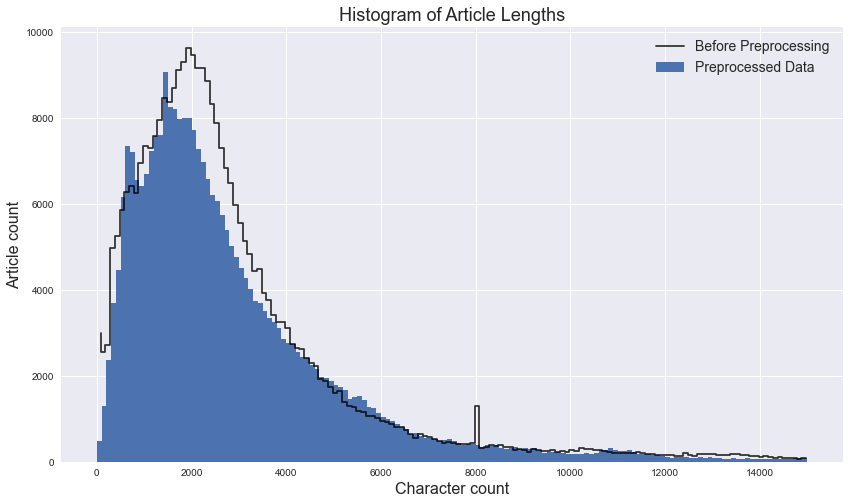

In [107]:
body_lengths = data['Body'].str.len()

desc = "A dent in article counts at 250 characters\nNot true"

y, bin_edges = np.histogram(body_lengths, bins=150, range=(0,15000))
x = 0.5*(bin_edges[1:] + bin_edges[:-1])

fig, ax = plt.subplots(1, figsize=(14,8))
plt.bar(x,y,width=np.diff(bin_edges), label="Preprocessed Data")
plt.step(x2+30, y2*0.41, 'k', alpha=0.8, label="Before Preprocessing")
plt.title("Histogram of Article Lengths", fontsize=18)
plt.xlabel("Character count", fontsize=16)
plt.ylabel("Article count", fontsize=16)
plt.legend(fontsize=14);
#plt.text(0.7, 0.7, desc, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=16)
#plt.plot([250,10000], [30,240], '--', c='red', alpha=.6)
#Ændr, så det passer med den endelige data.

dist_stats(body_lengths)

### Author contributions
How many articles have the authors written?

Mean: 159.58726790450928
STD: 430.7214839788824
Median: 27.0


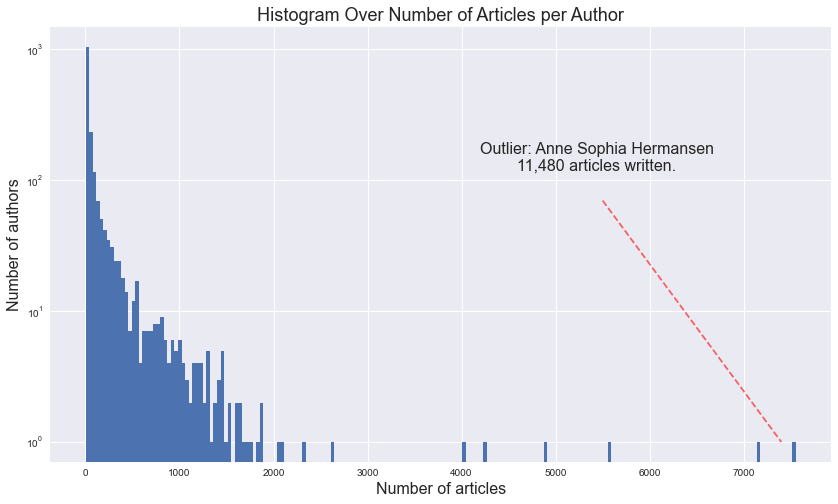

In [170]:
counts = list(data['Byline'].value_counts())

# plt.yscale('symlog')
# plt.xlim(-100,4000)

y, bin_edges = np.histogram(counts, bins=200)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])

fig, ax = plt.subplots(1, figsize=(14,8))
plt.bar(x,y,width=np.diff(bin_edges))

plt.yscale('log')
plt.title("Histogram Over Number of Articles per Author", fontsize=18)
plt.xlabel("Number of articles", fontsize=16)
plt.ylabel("Number of authors", fontsize=16)

desc = "Outlier: Anne Sophia Hermansen\n11,480 articles written."
plt.text(0.7, 0.7, desc, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=16)
plt.plot([5500,7400], [70,1], '--', c='red', alpha=.6)

dist_stats(counts)

### Author body length
Do authors have certain body lengths? In articles, not their actual bodies. Let us make a plot to see if there is a correlation between article count and body length. But first, we need to find the average body length per author. 

In [94]:
df = pd.DataFrame(columns=['body_length', 'author'])
df['body_length'] = body_lengths
df['author'] = data['Byline']
df['author'].replace('', np.nan, inplace=True)
df = df.dropna()
avg_body_lengths = list(df.groupby(['author']).mean()['body_length'])

Text(0, 0.5, 'Number of authors')

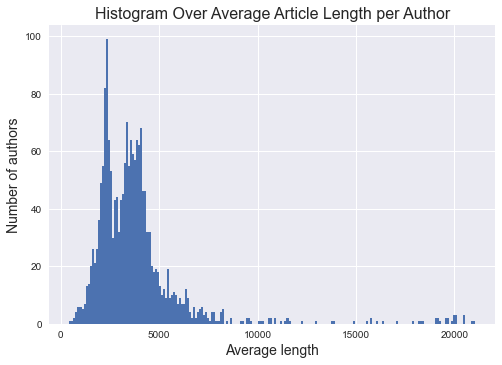

In [95]:
plt.hist(avg_body_lengths, bins=200);
plt.title("Histogram Over Average Article Length per Author", fontsize=16)
plt.xlabel("Average length", fontsize=14)
plt.ylabel("Number of authors", fontsize=14)

In [96]:
df2 = pd.DataFrame(index=data['Byline'].unique(),columns=['avg_len', 'article_count'])
avg_body_length_series = df.groupby(['author']).mean()['body_length']
article_count_series = data['Byline'].value_counts()

for i in data['Byline'].unique():
    if i == '':
        continue
    
    avg_len = avg_body_length_series[i]
    article_count = article_count_series[i]
    df2.loc[i] = [avg_len, article_count]

df2.head(5)

,avg_len,article_count
Annemette Grundtvig,1667.029091,550
Emma Busk,2360.276165,1137
Lasse Foghsgaard,1792.679412,340
Stine Kærgaard Nissen,787.315789,19
Kasper Villum Jensen,2216.770873,1593


**Correlation between average length and article count**

Make a dataframe with author, average article length, article count

Pearsin correlation: -0.012972263970456492


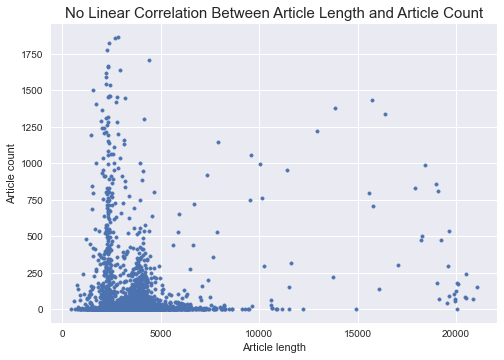

In [108]:
x = df2.avg_len
y = df2.article_count
plt.scatter(x[y<2000], y[y<2000], marker='.')
plt.ylabel("Article count")
plt.xlabel("Article length")

x = x.to_numpy(dtype=float)
y = y.to_numpy(dtype=float)
x = np.nan_to_num(x)
y = np.nan_to_num(y)

corr, sig = pearsonr(x,y)
print("Pearsin correlation:", corr)

plt.title("No Linear Correlation Between Article Length and Article Count", fontsize=15);

## Publication

In [138]:
dates = list(data.PublicationDate.str[8:10])
int_dates = []
old_af = []
future = []
for i in dates:
    try:
        inti = int(i)
    except:
        continue
    
#     if inti < 1995:
#         old_af.append(inti)
#         continue
    if inti > 22:
        future.append(inti)
        continue
    int_dates.append(inti)

print(len(old_af), "articles from before 1995")
print(len(future), "articles from the future")

0 articles from before 1995
5010 articles from the future


c:\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


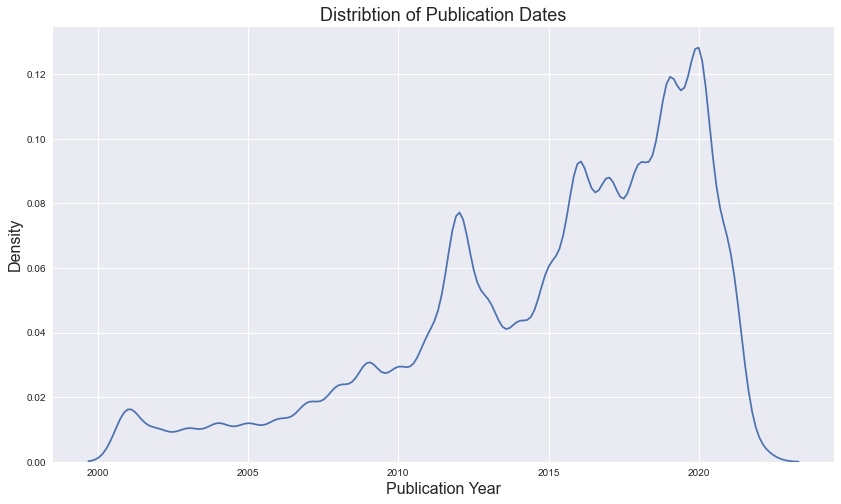

In [168]:
import seaborn as sns

fig, ax = plt.subplots(1, figsize=(14,8))
sns.distplot(int_dates, hist=False)
plt.title("Distribtion of Publication Dates", fontsize=18)
plt.xlabel("Publication Year", fontsize=16)
plt.ylabel("Density", fontsize=16)
ax.set_xticklabels(plt.xticks[0].astype(int));

### Headline length

Mean: 57.068864644208205
STD: 22.750211363106228
Median: 54.0


AndersonResult(statistic=2802.0388447247096, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

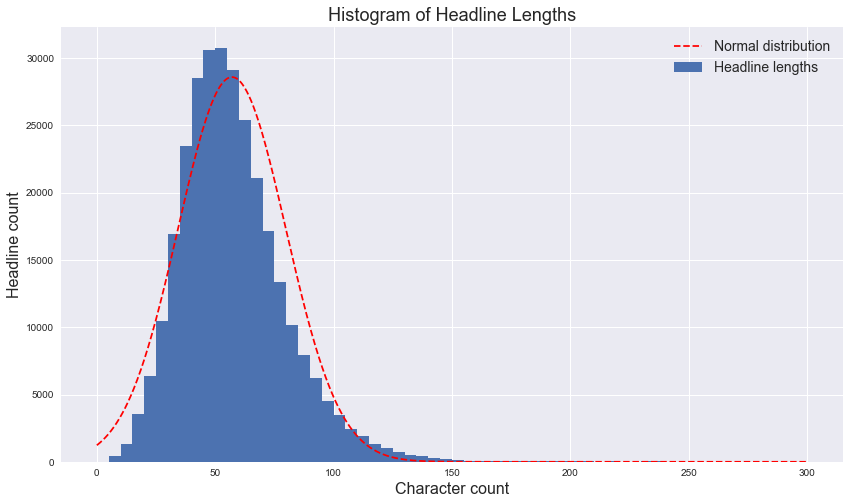

In [238]:
from scipy.stats import anderson

def normal_dist(x , mean , sd):
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

header_lengths = sorted(data['Header'].str.len())

y, bin_edges = np.histogram(header_lengths, bins=50, range=(0,250))
x = 0.5*(bin_edges[1:] + bin_edges[:-1])

fig, ax = plt.subplots(1, figsize=(14,8))
plt.bar(x,y,width=np.diff(bin_edges), label="Headline lengths")
plt.title("Histogram of Headline Lengths", fontsize=18)
plt.xlabel("Character count", fontsize=16)
plt.ylabel("Headline count", fontsize=16)

norm = normal_dist(np.linspace(0,300,1000), np.mean(header_lengths), np.std(header_lengths))
plt.plot(np.linspace(0,300,1000), norm*400, '--', c='red', label="Normal distribution")
plt.legend(fontsize=14)

dist_stats(body_lengths)
anderson(header_lengths)

In [242]:
dist_stats(list(data.Domain.value_counts()))

Mean: 1880.1375
STD: 7478.047291478822
Median: 159.0


# Testing

In [73]:
data = pd.read_json('Data/additional/scraped_data_raw.json')

In [5]:
def split_sentences(text):
    '''Returns an array with text split into sentences'''
    return np.array(re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text), dtype=str)

In [6]:
#Write body sentences to file.
texts = list(data.head(20000).Body.astype(str))
final_text = ''
for text in tqdm(texts):
    phrase = phrase.strip('\n')
    final_text += ''.join(phrase)
    final_text += '\n'
    
final_text = final_text[:-1]

  0%|          | 0/20000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
with open('text.txt', 'w', encoding='utf-8') as f:
    f.write(final_text)

In [106]:
lens = [len(x) for x in final_text.split('\n')]

In [107]:
z = [x for x in range(len(lens)) if lens[x] == 0]

In [29]:
#Cell for writing bodies to file

files = os.listdir('data/additional/scraped')
files = [x for x in files if x[-4:]=='json'] #only take .json files.

final_text = []
for file in tqdm(files):
    df = pd.read_json('data/additional/scraped/'+file)
    del df['level_0']
    del df['index']
    
    texts = list(df.Body.astype(str))
    
    for text in tqdm(texts):
        text = text.strip()
        text = text.replace('\n','')
        text = text.replace('\r','')
        text = text.replace('\t','')
        if len(text) < 10:
            continue
        final_text.append(text+'\n')
    
with open('bodies.txt', 'w', encoding='utf-8') as f:
    f.writelines(final_text)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/822 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [11]:
with open('bodies.txt', 'w', encoding='utf-8') as f:
    f.write(final_text)

In [143]:
st = data[data.Header.str.contains('Bredt forlig giver 607 millioner til udsatte grupper')]

In [144]:
st = list(st.Header.astype(str))[0]

In [8]:
final_text.split('\n')[0]

'Utilfreds passager: »Prøv selv en tur klokken 7.30 en hverdagsmorgen« - politiken.dk'

In [82]:
'Corona rammer tøjimport for milliarder:\xa0Kan ikke bruge shorts i oktober\n\n | avisendanmark.dk'.strip('\n')

'Corona rammer tøjimport for milliarder:\xa0Kan ikke bruge shorts i oktober \n \n | avisendanmark.dk'

In [129]:
with open('headers.txt', encoding='utf-8') as f:
    b = f.readlines()

In [130]:
lens = [len(x) for x in b.split('\r')]
z = [x for x in range(len(lens)) if lens[x] == 0]
z

AttributeError: 'list' object has no attribute 'split'

In [131]:
np.argmin([len(x) for x in b])

11232

In [4]:
files = os.listdir('scraped')
files = [x for x in files if x[-4:]=='json'] #only take .json files.

data = pd.read_json('scraped/'+files[0])
for file in tqdm(files[1:]):
    data = pd.concat([data, pd.read_json('scraped/'+file)])

  0%|          | 0/30 [00:00<?, ?it/s]

In [157]:
anal = pd.read_json('data/additional/scraped/data_30.json')
analbodies = list(anal.Body.astype(str))

In [19]:
with open('bodies.txt', encoding='utf-8') as f:
    b = f.readlines()

In [22]:
len(b[0])

21938631

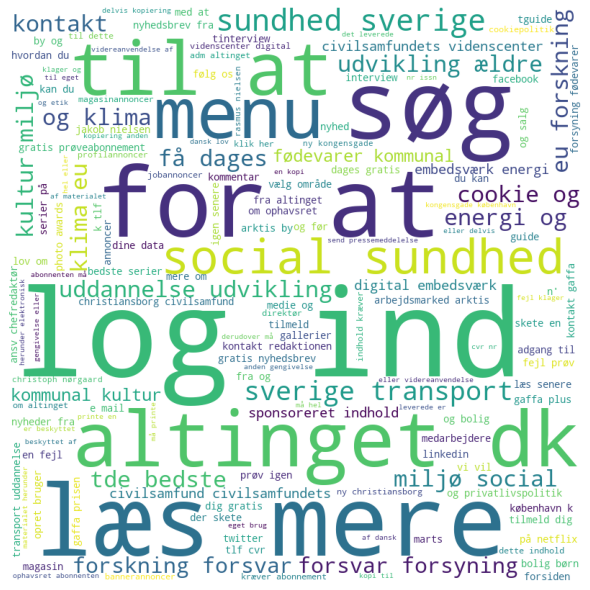

In [50]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

sw = ['t', 'n' 'avis', 'forfatter', '\n', 'r', 'N', 'xa0']
 
comment_words = ''
stopwords = set(sw)
 
# iterate through the csv file
for val in domain_junk.values():
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('wordcloud.png')

In [49]:
plt.savefig('wordcloud.png')

<Figure size 576x396 with 0 Axes>

In [47]:
plt.show()

In [1]:
import numpy as np
import pickle

In [8]:
del output
with open('Classification results/xtra_NA_manual_RF_classsification.dat', 'rb') as f:
    output = pickle.load(f)

In [9]:
output['metrics'], output['proctime']

({'correct': 17443,
  'accuracy': 0.7377347318558619,
  'bal_accuracy': 0.7112430311478868,
  'f1': 0.732489176826142,
  'auc': 0.9757045706008266,
  'top5_accuracy': 0.9377431906614786,
  'cohen': 0.726556715480293},
 '0:02:40.591848')

In [111]:
p = 'Data/xtra_clean_authors/'
data = pd.concat([pd.read_json(p+file) for file in tqdm(os.listdir(p))])

dif_domains = []
unique_authors = data['Byline'].unique()
for author in tqdm(unique_authors):
    dif_domains.append(len(data[data['Byline'] == author]['Domain'].unique()))
    if len(data[data['Byline'] == author]['Domain'].unique()) > 10:
        print(author)

p = 'Data/xtra_clean_domains/'
data = pd.concat([pd.read_json(p+file) for file in tqdm(os.listdir(p))])

dif_authors = []
unique_domains = data['Domain'].unique()
for domain in tqdm(unique_domains):
    dif_authors.append(len(data[data['Domain'] == domain]['Byline'].unique()))
    if len(data[data['Domain'] == domain]['Byline'].unique()) > 500:
        print(domain)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Sacha Sennov


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

politiken.dk


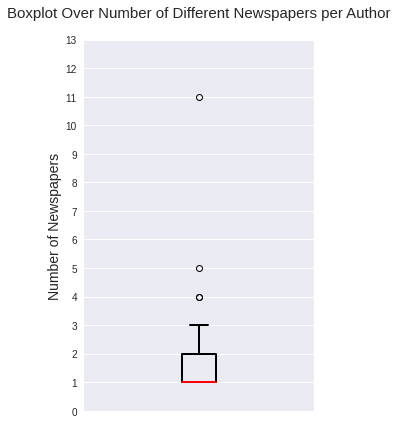

In [115]:
fig = plt.figure(figsize=(4,6))
bp = plt.boxplot(dif_domains)
plt.yticks(range(14));
plt.xticks([]);

for collection in bp.keys():
    for line in bp[collection]:
        if collection == 'medians':
            line.set_color('red')
        line.set_linewidth(2)

plt.title("Boxplot Over Number of Different Newspapers per Author\n", fontsize=15)
plt.ylabel("Number of Newspapers", fontsize=14)
plt.tight_layout()
plt.savefig('figs/bp_domains_per_author.png', dpi=300, bbox_inches = "tight")

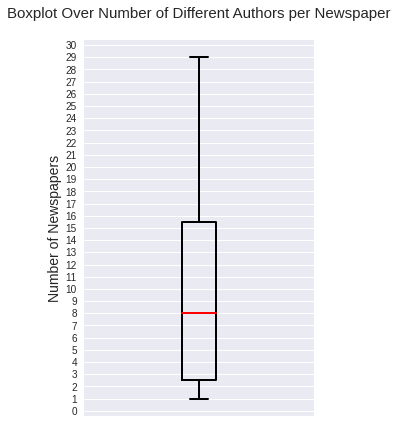

In [114]:
fig = plt.figure(figsize=(4,6))
bp = plt.boxplot(dif_authors, sym='')
plt.yticks(range(31));
plt.xticks([]);

for collection in bp.keys():
    for line in bp[collection]:
        if collection == 'medians':
            line.set_color('red')
        line.set_linewidth(2)

plt.title("Boxplot Over Number of Different Authors per Newspaper\n", fontsize=15)
plt.ylabel("Number of Newspapers", fontsize=14)
plt.tight_layout()
plt.savefig('figs/bp_authors_per_domain.png' ,dpi=300, bbox_inches = "tight")

In [7]:
def encode(text):
        '''Text is simply just converting string to array'''
        text = text.replace('<start>', '')
        text = text.replace('<end>', '')
        text = text.replace(' ', '')
        text = text.replace('[', '')
        text = text.replace(']', '')
        return np.fromstring(text, dtype=float, sep=',')

In [123]:
encode("dhhb")

/tmp/ipykernel_290/1821636408.py:8: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  return np.fromstring(text, dtype=float, sep=',')


array([], dtype=float64)

In [1]:
import pickle
with open('svd_train_data.dat', 'rb') as f:
    svd = pickle.load(f)
    
with open('raw_train_data.dat', 'rb') as f:
    raw = pickle.load(f)

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pickle

In [11]:
for i in tqdm(svd):
    hest = encode(i[0])
    if hest.shape[0] != 8000:
        print(hest.shape)

  0%|          | 0/42985 [00:00<?, ?it/s]

In [18]:
for i in tqdm(raw):
    hest = encode(i[0])
    if hest.shape[0] != 10332:
        print(hest.shape)

  0%|          | 0/171936 [00:00<?, ?it/s]

In [22]:
encode(raw[0][0]).dtype, encode(svd[0][0]).dtype, 

(dtype('float64'), dtype('float64'))

In [4]:
with open("Classification results/Random_Forest/xtra_NA_combined_RF_classsification.dat", 'rb') as f:
    output = pickle.load(f)

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.0 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.1.0 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
rfc = output['fedtet_estimator']

In [ ]:
rfc.predict(